## 2.3 Key features and target

- Features:
  - cay_FC
  - cay_MS (MLE and Gibbs)
  - Macroeconomic controls

- Target:
  - Future equity returns over horizons:
    - 1 quarter
    - 4 quarters
    - 16 quarters

## 2.4 Preprocessing

- Log-transformations applied to consumption and wealth.
- PCA computed on standardized macro factor matrix.
- Missing values handled via last observation carried forward within macro controls.
- Future return targets constructed via rolling window sums of quarterly returns.

---

We will proceed to 3. Feature Engineering next. Let me know to continue.


## 3.4 Regime switching indicators

### 3.4.1 MLE-based regime probabilities

Markov-switching regressions (Hamilton filter) were estimated to obtain smoothed regime probabilities and cay_MS fitted values.

### 3.4.2 Bayesian Gibbs-based regime probabilities

Custom Gibbs sampler with macro controls was implemented, yielding:

- Posterior samples for regime-dependent parameters (α, β)
- Inferred state sequences (regime allocations)
- cay_MS residual series constructed accordingly

## 3.5 Correlation analysis

Pairwise correlations and scatter plots were used to assess the predictive relationship between constructed CAY variables and future returns at various horizons.

## 3.6 Autocorrelation and PACF

Autocorrelation (ACF) and Partial Autocorrelation (PACF) functions of residual series were analyzed to detect persistence patterns and mean-reversion signals.

---

Next is 4. Baseline Model. Let me know to continue.



In [14]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import pandas_datareader.data as web
import statsmodels.api as sm
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
import matplotlib.pyplot as plt
import yfinance as yf
from utils import *
from models import *
import seaborn as sns
import arviz as az

import numpy as np
import random

# Set seed for reproducibility
SEED = 45
np.random.seed(SEED)
random.seed(SEED)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 📓 Bianchi et al. (2016) Replication and Extension

## Contents

1. Introduction
   - Project objective and theoretical motivation
   - Overview of Bianchi et al. (2016) model

2. Data Preparation
   - Data sources and description
   - Cleaning and transformation
   - Construction of cay_FC (cointegration residual)

3. Markov Regime-Switching Models
   - Simple MLE-based Markov regression (statsmodels)
   - Bayesian Gibbs sampler implementation
     - Regime-dependent intercepts (α_s)
     - Regime-dependent slopes (β_s)
     - Ordering constraints
     - Hamilton filter and backward sampling
   - Posterior regime probability plots

4. Forecasting Regressions
   - Multi-horizon forecasts (1, 4, 16 quarters)
   - Comparison: cay_FC vs. cay_MS as predictors
   - Regression result tables and interpretations

5. Macro Controls Integration
   - Rationale for inclusion
   - Data fetching and preparation
   - Augmented forecasting regressions

6. Model Extensions
   - Regime-dependent variances (σ²_s)
   - Multi-chain convergence diagnostics
   - MLE vs. Bayesian regime classification comparison

7. Out-of-Sample Evaluation
   - Rolling window forecasting setup
   - Performance analysis

8. Discussion and Conclusion
   - Key findings
   - Limitations
   - Possible future extensions

9. Appendix
   - Full Gibbs sampler code
   - Additional plots and diagnostics


# Table of Contents

1. [Introduction](#introduction)
2. [Data Overview](#data-overview)
3. [Methodology](#methodology)
    - [Markov Switching (MLE)](#markov-switching-mle)
    - [Gibbs Sampling Bayesian MS](#gibbs-sampling-bayesian-ms)
4. [Macro Controls](#macro-controls)
5. [Forecasting Pipeline](#forecasting-pipeline)
6. [Results](#results)
7. [Discussion](#discussion)
8. [Conclusion and Next Steps](#conclusion-and-next-steps)


# 1. Introduction

This notebook replicates and extends the core findings of Bianchi et al. (2016), who propose that allowing for Markov regime-switching in the consumption-wealth-income (cay) cointegration relationship yields improved insights into expected returns and economic dynamics. Therefore this notebook will investigate the predictive power of different implementations of the consumption-wealth ratio (CAY) for forecasting equity returns. Specifically, we compare:

- Traditional forecast combinations (FC)
- Markov Switching models estimated via Maximum Likelihood (MS MLE)
- Bayesian Markov Switching models estimated via Gibbs sampling (MS Gibbs)

We also evaluate the role of macroeconomic controls, examining:

- Whether including macro variables improves forecast accuracy when models are built without them
- Whether models estimated with macro controls outperform those without

The aim is to assess their performance, by conducting rolling window out-of-sample evaluations. This will allow us to compare the predictive power of these models in a robust manner, focusing on their ability to forecast equity returns. Our key evaluation metrics will include:

- Predictive R²
- Root Mean Squared Error (RMSE)
- Sharpe ratio of implied trading strategies

We build a clean pipeline for comparative evaluation, robust interpretation, and potential trading signal extraction.

### Theoretical Motivation

The standard cay measure, constructed via a fixed-coefficient cointegration regression, assumes stable long-run relationships between consumption (ct), labor income (yt), and asset wealth (at). However:

- Structural breaks or non-linearities may violate this assumption.  
- Markov regime-switching models allow for discrete changes in the intercept and slope parameters, capturing potential shifts in economic behavior or policy regimes.

Bianchi et al. (2016) show that:

- Allowing the cointegration intercept and/or slope to switch regimes (denoted cay_MS) produces time-varying residuals that better align with asset pricing implications of habit and long-run risk models.  
- Predictive regressions using cay_MS may yield sharper forecasts and more theoretically consistent economic interpretations.


# 2. Data Overview

We utilize a in this notebok the following macro-finance dataset containing:

- Real Personal Consumption Expenditures (`log_ct`): Log of real personal consumption expenditures
- Compensation of Employees (`log_yt`): Log of aggregate household net worth
- Households; Net Worth (`log_at`): Log of household net worth
- PCA factor (`pca`): First principal component derived from macro factors
- Macro controls:
  - interest_rate: Short-term interest rate (e.g. 3-month Treasury bill)
  - CPI_inflation: Consumer Price Index inflation rate
  - unemployment: Civilian unemployment rate
- Returns (`future_ret_Xq`): S&P 500 index returns at various forecast horizons (1, 4, 16 quarters)

<div align="center">

| Variable      | Frequency | Source |
|-------------------|---------------|------------|
| `log_ct`          | Quarterly     | National Accounts (FRED: `PCECC96`) |
| `log_yt`          | Quarterly     | National Accounts (FRED: `WASCUR`) |
| `log_at`          | Quarterly     | National Accounts (FRED: `BOGZ1FL192090005Q`) |
| `pca`             | Quarterly     | Derived from macro factors |
| `interest_rate`   | Monthly       | FRED (`FEDFUNDS`) |
| `CPI_inflation`   | Monthly       | FRED (`CPIAUCSL`) |
| `unemployment`    | Monthly       | FRED (`UNRATE`) |
| `Returns (SP500)` | Daily/Monthly/Quarterly | YahooFinance (`^GSPC`) |

</div>

#### Note

All variables were merged into a quarterly panel for baseline and forecast model estimation. 

In [3]:
df = load_macro_data()
returns = load_sp500_excess_returns()
pca = compute_pca(df)
df =merge_macro_excess_returns(df, returns)
horizons = create_horizons(df)
df = add_macro_features(df)

macro_controls = ['interest_rate', 'CPI_inflation', 'unemployment']

/Users/stefan/VSCode/regime_switching/utils.py:90: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download('^GSPC', start=start, end=end, interval='1mo')
[*********************100%***********************]  1 of 1 completed


### 3. Feature Engineering

### Seasonal decomposition

Although not implemented in the final pipeline due to quarterly frequency smoothness, seasonal decomposition was tested on macro variables to inspect seasonal patterns. This approach can be reintroduced if monthly data are used.

### PCA factor construction

A Principal Component Analysis (PCA) was performed on the standardized macro factor matrix to extract the first principal component (pca), used as a parsimonious representation of macroeconomic variation.

This is because PCA is a dimensionality reduction technique that captures the main common factor driving variation across multiple correlated variables. In this project, PCA was used to derive a single factor (`pca`) summarizing the strongly correlated 'log_yt' and 'log_at' macroeconomic indicators.

### Target shifting

Future returns were constructed by shifting cumulative returns forward:

- future_ret_1q: Return over next quarter
- future_ret_4q: Return over next 4 quarters
- future_ret_16q: Return over next 16 quarters

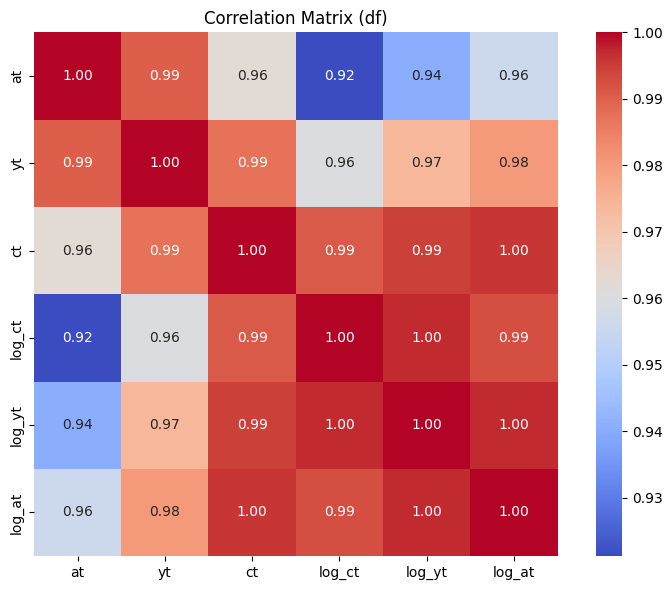

In [4]:
# Compute correlation matrix for df
corr = df[['at','yt', 'ct', 'log_ct', 'log_yt', 'log_at']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Matrix (df)')
plt.tight_layout()
plt.show()

### 3.1 Construction of cay_FC (Fixed-Coefficient cay)

Following Lettau and Ludvigson (2001), we define:

$$
cay_{FC} = c_t - \alpha - \beta y_t - \gamma a_t
$$

where:

- $ c_t $ is log consumption  
- $ y_t $ is log labor income  
- $ a_t $ is log asset wealth

The parameters $ \beta $ and $ \gamma $ are estimated via cointegration regression (OLS) assuming fixed coefficients over the sample.

---


In [ ]:
df, model_fc_yt = estimate_cay_FC_yt(df)
df, model_fc_pca = estimate_cay_FC_pca(df)

                            OLS Regression Results                            
Dep. Variable:                 log_ct   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                 2.506e+04
Date:                Fri, 04 Jul 2025   Prob (F-statistic):          4.00e-166
Time:                        09:10:36   Log-Likelihood:                 356.65
No. Observations:                 149   AIC:                            -709.3
Df Residuals:                     147   BIC:                            -703.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.7787      0.034    109.812      0.0

### 4. Markov-Switching Approach

In this section, we describe the Markov-switching (MS) framework used in our models. This includes both:

- Standard MS models without macro controls
- Extended MS models incorporating macro controls as predictors

We will use two different estimation Approaches:

(i). MLE-based Markov Regression

- Uses Hamilton filter to compute regime probabilities and estimate parameters by maximizing likelihood.
- Implemented via `statsmodels.tsa.regime_switching.MarkovRegression`.

(ii). Gibbs Sampling with Macro Controls

- Bayesian approach sampling from posterior distributions of parameters and regimes.
- Extends standard Gibbs sampler to include macro controls in each iteration’s regression step.
- Provides full uncertainty quantification for parameters and latent states.

### Practical Implications

- Without macro controls: Regime differences capture all structural shifts.
- With macro controls: Regimes capture structural shifts not explained by observable macro variables.

This distinction is critical when interpreting results:
<div align="center">

| Model | Regime variation | Macro variation |
|---|---|---|
| MS without macro | Captures both structural and macro effects implicitly | No explicit macro coefficients |
| MS with macro | Structural regime shifts net of macro effects | Explicit macro coefficients estimated |

</div>

### Conceptual Overview

The Markov-switching regression model allows for different regimes or states in the data-generating process. For example:

- A bull market regime with high expected returns
- A bear market regime with low or negative expected returns

Regime changes are governed by an unobserved Markov process, meaning that:

- The probability of switching to another regime depends only on the current state (Markov property).
- Regimes are persistent but transitions can occur with estimated probabilities.

### Model Without Macro Controls

### Mathematical Formulation

Let:

- $ y_t $ = dependent variable (e.g. log consumption)
- $ x_t $ = independent variable (e.g. log income or PCA factor)
- $ s_t $ = latent regime indicator at time t, taking values in {1, 2}

Then the regime-switching regression model is:

\begin{align}
y_t &= \alpha_{s_t} + \beta_{s_t} x_t + \varepsilon_t \\

\text{Where: } \quad & \\
 \alpha_{s_t} & \text{ Regime-dependent intercept} \\
 \beta_{s_t} & \text{ Regime-dependent slope} \\
 \varepsilon_t & \sim N(0, \sigma^2)  \text{ iid normal error}
\end{align}

### Regime Transition

The regimes evolve according to a first-order Markov process with transition matrix $P$:

<div align="center">

$
P = 
\begin{bmatrix}
p_{11} & p_{12} \\
p_{21} & p_{22}
\end{bmatrix}
$

</div>

Transition probability matrix for a 2-state Markov process.

where:

$$ p_{ij} = P(s_t = j | s_{t-1} = i) $$

### Model With Macro Controls

### Motivation

Incorporating macroeconomic control variables allows us to explain additional variation in the dependent variable that is not captured by regime switching alone.

### Mathematical Formulation

Let:

- $ Z_t $ = vector of macro controls (interest rate, inflation, unemployment)
- $ \gamma $ = vector of regime-invariant macro coefficients

The extended model becomes:

$$
y_t = \alpha_{s_t} + \beta_{s_t} x_t + \gamma' Z_t + \varepsilon_t
$$

where:

- $ \gamma $ is constant across regimes, assuming macro controls have stable effects.


In [10]:
## Markov Switching Model Estimation with out macro controls
ms_model_cay_yt = MarkovRegression(df['cay_FC_yt'], k_regimes=2, trend='c',
                                switching_variance=True)
ms_result_cay_yt = ms_model_cay_yt.fit(em_iter=0)
fitted_ms_cay_yt = ms_result_cay_yt.fittedvalues

df['cay_MS_MLE_yt'] = df['cay_FC_yt'] - fitted_ms_cay_yt


ms_model_cay_pca = MarkovRegression(df['pca'], k_regimes=2, trend='c',
                                switching_variance=True, )
ms_result_cay_pca = ms_model_cay_pca.fit(em_iter=0)
fitted_ms_cay_pca = ms_result_cay_pca.fittedvalues
df['cay_MS_MLE_pca'] = df['pca'] - fitted_ms_cay_pca




In [9]:
## Markov Switching Model Estimation with macro controls
ms_model_cay_yt_macro = MarkovRegression(df['cay_FC_yt'], k_regimes=2, trend='c', exog=df[macro_controls],
                                switching_variance=True)
ms_result_cay_yt_macro = ms_model_cay_yt_macro.fit(em_iter=0)
fitted_ms_cay_yt_macro = ms_result_cay_yt_macro.fittedvalues

# Compute cay_MS_MLE as deviation from fitted
df['cay_MS_MLE_yt_macro'] = df['log_ct'] - fitted_ms_cay_yt_macro

ms_model_cay_pca_macro = MarkovRegression(df['pca'], k_regimes=2, trend='c', exog=df[macro_controls],
                                switching_variance=True, )
ms_result_cay_pca_macro = ms_model_cay_pca_macro.fit(em_iter=0)
fitted_ms_cay_pca_macro = ms_result_cay_pca_macro.fittedvalues
df['cay_MS_MLE_pca_macro'] = df['log_ct'] - fitted_ms_cay_pca_macro

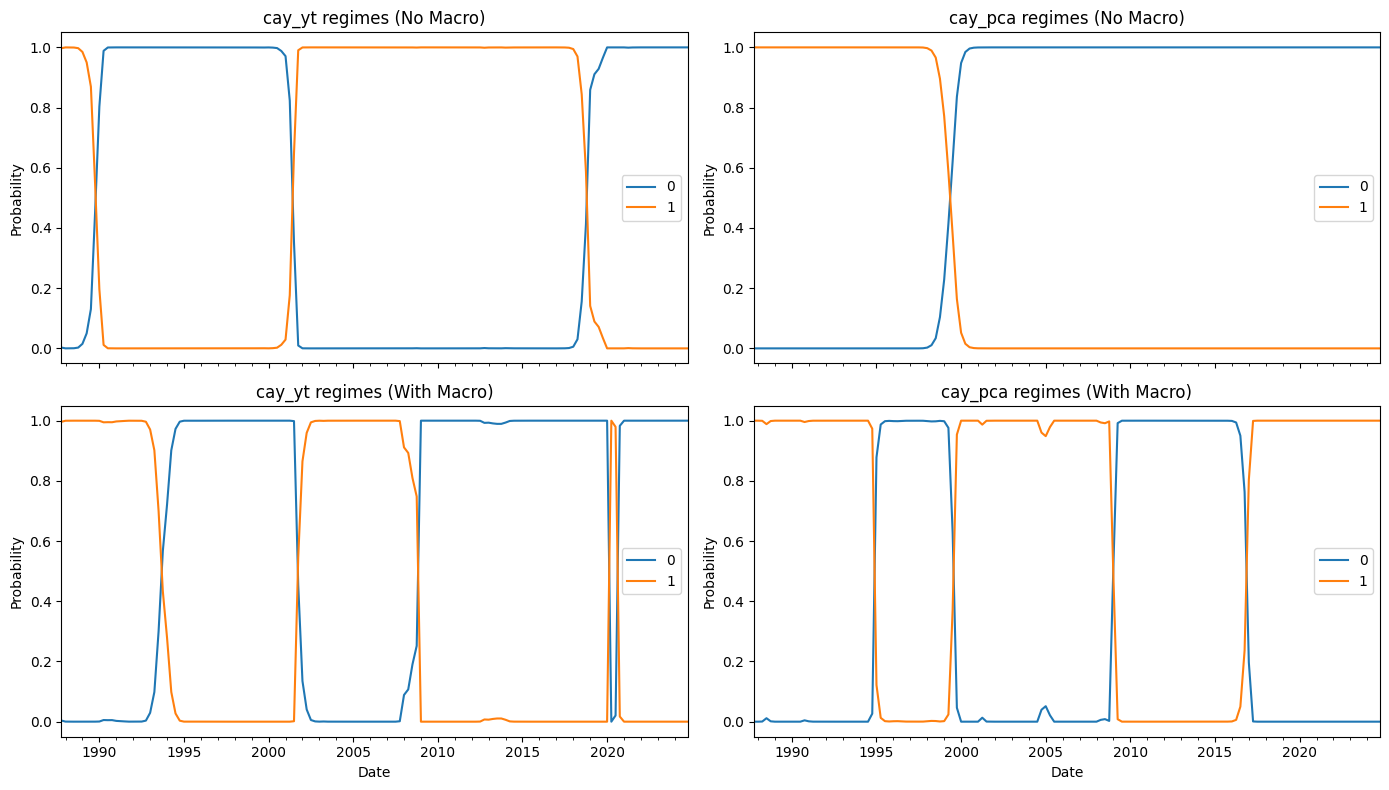

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex=True)

# Top row: no macro controls
smoothed_probs_yt = ms_result_cay_yt.smoothed_marginal_probabilities
smoothed_probs_yt.plot(ax=axes[0, 0], title='cay_yt regimes (No Macro)')
axes[0, 0].set_ylabel('Probability')
axes[0, 0].set_xlabel('Date')

smoothed_probs_pca = ms_result_cay_pca.smoothed_marginal_probabilities
smoothed_probs_pca.plot(ax=axes[0, 1], title='cay_pca regimes (No Macro)')
axes[0, 1].set_ylabel('Probability')
axes[0, 1].set_xlabel('Date')

# Bottom row: with macro controls
smoothed_probs_yt_macro = ms_result_cay_yt_macro.smoothed_marginal_probabilities
smoothed_probs_yt_macro.plot(ax=axes[1, 0], title='cay_yt regimes (With Macro)')
axes[1, 0].set_ylabel('Probability')
axes[1, 0].set_xlabel('Date')

smoothed_probs_pca_macro = ms_result_cay_pca_macro.smoothed_marginal_probabilities
smoothed_probs_pca_macro.plot(ax=axes[1, 1], title='cay_pca regimes (With Macro)')
axes[1, 1].set_ylabel('Probability')
axes[1, 1].set_xlabel('Date')

plt.tight_layout()
plt.show()


### Regime Probability Plots Interpretation

#### Figure Summary and observations

- Top row: Models *without macro controls*
  - Left: `cay_yt` regimes
  - Right: `cay_pca` regimes
- Bottom row: Models *with macro controls*
  - Left: `cay_yt` regimes
  - Right: `cay_pca` regimes

Each plot shows the smoothed filtered probabilities of being in regime 0 or 1 over time. We observe the following:

1. Strong regime switching patterns  
   All models show clear, near-binary switching between regime 0 and 1, indicating well-separated states.

2. Effect of macro controls  
   In the bottom plots (with macro):
   - Transitions remain similar in timing to the top plots but are slightly smoother in some periods (e.g. around 2008 or 2020), reflecting that macro controls absorb part of the variation and stabilize estimation.
   - Occasional flickering (rapid switching) is seen, suggesting macro variables introduce additional explanatory variance.

3. Duration differences between models  
   - `cay_pca` models (right column) tend to stay longer in one regime, producing more stable state classification.
   - `cay_yt` models (left column) show more frequent switches, especially in the with-macro model around 2020.

4. Economic interpretation  
   Regime 0 and 1 typically capture different market conditions:
   - For instance, regime 0 could align with normal growth, while regime 1 with recession or stress periods.
   - Macro controls help models attribute part of the regime differentiation to observable macro factors, but unobserved switching remains dominant.

#### Potential Concerns

- Overly deterministic regimes: Near-0 or near-1 probabilities over long periods indicate little uncertainty; may suggest overfitting or lack of stochastic switching.
- Misspecification risk: If regimes never switch (e.g. `cay_pca` top-right post-2000), this questions the usefulness of a switching model versus a single-regime model.

-----------------


### Gibbs Sampling Approach

In this section, we describe the Bayesian Gibbs sampling framework used to estimate our regime-switching models. This includes:

- Standard Gibbs sampling without macro controls
- Extended Gibbs sampling with macro controls

### Conceptual Overview

The Gibbs sampler is a Markov Chain Monte Carlo (MCMC) method used to sample from complex joint posterior distributions by:

1. Sequentially sampling each parameter conditional on the others
2. Iterating until convergence to the joint posterior distribution

In regime-switching models, Gibbs sampling allows us to:

- Estimate latent regime indicators $ s_t $
- Sample regime-dependent parameters ($ \alpha_s, \beta_s $)
- Incorporate parameter uncertainty in forecasts and inferences

As before by adding macro controls, we allow the separation of:

- Regime effects (structural shifts)
- Macro effects (observable explanatory variables)

### Mathematical Formulation

The standard Gibbs sampler assumes:

- Without macro controls:

$$
y_t = \alpha_{s_t} + \beta_{s_t} x_t + \varepsilon_t
$$

- With macro controls:

$$
y_t = \alpha_{s_t} + \beta_{s_t} x_t + \gamma' Z_t + \varepsilon_t

$$

where:

\begin{aligned}
  s_t & \text{ is the latent regime at time t} \\
  \alpha_{s_t}, \beta_{s_t} & \text{ are regime-dependent intercept and slope} \\
  \gamma & \text{ is the vector of macro coefficients, assumed constant across regimes} \\
  \varepsilon_t & \sim N(0, \sigma^2) \text{ iid normal error}
\end{aligned}


#### Without macro controls each iteration:

1. Sample latent states $ s_t $ using Hamilton filter and backward sampling
2. Sample regime-dependent parameters ($ \alpha_s, \beta_s $) given assigned states
3. Sample error variance $ \sigma^2 $
4. Sample transition probabilities for the regime Markov process


#### With macro controls each iteration:

1. Sample latent states $ s_t $ conditional on current parameters
2. Sample regime-dependent parameters ($ \alpha_s, \beta_s $) net of macro effects
3. Sample macro coefficients $ \gamma $ as regime-invariant linear regression coefficients
4. Sample error variance $ \sigma^2 $
5. Sample regime transition probabilities


This generates a joint posterior sample over all model parameters and regimes.

### Advantages of Gibbs Sampling

<div align="center">

| Feature | Advantage |
|---|---|
| Bayesian inference | Provides full posterior distributions rather than point estimates |
| Latent states | Generates samples of regime sequences $ s_t $ for uncertainty quantification |
| Flexibility | Easily extends to include macro controls or hierarchical priors |

</div>

### Gibbs Sampler Stability Checks

After estimating our Bayesian regime-switching models via Gibbs sampling, it is critical to assess stability and convergence to ensure reliable inference. This is as the Gibbs sampler produces a Markov chain whose stationary distribution is the posterior distribution of model parameters.

However:

- The chain may fail to converge if the sampler is poorly designed
- Samples may exhibit high autocorrelation, reducing effective sample size
- Without diagnostics, inferences based on the sampler can be biased or misleading


To address these concerns, we perform several key diagnostics:

### Trace Plots

- Plot parameter values over iterations
- Convergence is indicated by:
  - Lack of drift over iterations
  - Visual mixing across the sample space

### Effective Sample Size (ESS)

\begin{align}
ESS & = \frac{N}{1 + 2 \sum_{k=1}^{\infty} \rho_k} \\


\text{Where: } \quad & \\
 N & \text{ is the number of post-burn-in samples} \\
\rho_k & \text{ is the autocorrelation at lag k}

\end{align}

Where:


### Interpretation: Higher ESS means more independent information despite autocorrelation.


### R-hat Diagnostic (Gelman-Rubin)

For multiple chains:

$$
\hat{R} = \sqrt{ \frac{\hat{V}}{W} }
$$

Where:

- $ \hat{V} $ is the estimated variance across chains
- $ W $ is the average within-chain variance

### Interpretation:

- $ \hat{R} \approx 1 $: Convergence achieved
- $ \hat{R} > 1.1 $: Potential non-convergence


### Posterior Distribution Plots

- Visualize marginal posterior distributions
- Identify multimodality, skewness, or irregular shapes indicating sampling issues.


### Practical Implementation in Our Pipeline

We perform:

1. Multiple chain sampling
2. Trace plots for key parameters ($ \alpha_s, \beta_s, \gamma $)
3. R-hat and ESS diagnostics using ArviZ
4. Reporting summary statistics with:

```python
az.summary(posterior)


# 4. Baseline Model

## 4.1 Mean model benchmark

As a baseline, a simple historical mean model was used for out-of-sample forecast comparison. This naive model predicts future returns as the mean of past observed returns within the rolling or expanding window.

### Implementation

For each evaluation window:

- Compute the mean of in-sample returns
- Predict out-of-sample returns using this mean

## 4.2 Baseline metrics

Performance metrics for the mean model (serving as benchmark for R² calculation):

- R² (Out-of-Sample): Proportion of variance explained relative to this mean model. Negative values indicate underperformance.
- RMSE: Root Mean Squared Error.
- Sharpe Ratio (annualized): Mean predicted return divided by its standard deviation, scaled to annual frequency for interpretability.

The mean model establishes a low benchmark; financial return forecasting models must outperform this to be economically viable.

---

Next is 5. Machine Learning Models. Confirm to continue or specify adjustments.


In [4]:
baseline_results, baseline_metrics = baseline_mean_forecast(df, target='future_ret_1q', window_size=40, expanding=True)

🔷 Baseline Mean Model Performance:
R² (OOS): -0.0129
RMSE: 0.0843
Sharpe Ratio (annualized): 11.9845
✅ Baseline mean forecast results saved to results/baseline_mean_results.csv


Running Chain 1/4 with seed 42
Running Chain 2/4 with seed 43
Running Chain 3/4 with seed 44
Running Chain 4/4 with seed 45


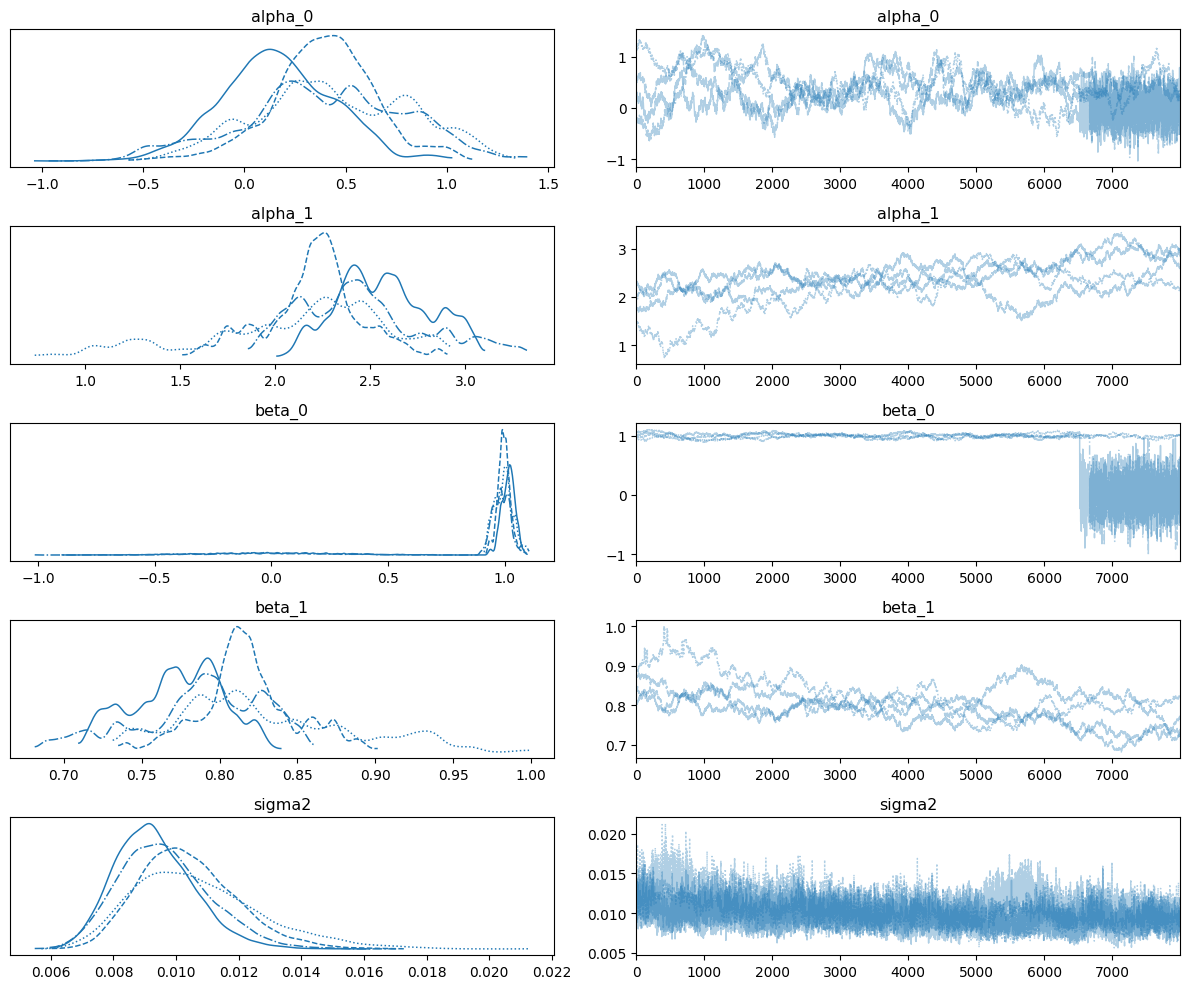

Effective Sample Sizes (ESS):
<xarray.Dataset> Size: 40B
Dimensions:  ()
Data variables:
    alpha_0  float64 8B 42.58
    alpha_1  float64 8B 7.05
    beta_0   float64 8B 32.46
    beta_1   float64 8B 7.056
    sigma2   float64 8B 15.22
R-hat Diagnostics:
<xarray.Dataset> Size: 40B
Dimensions:  ()
Data variables:
    alpha_0  float64 8B 1.101
    alpha_1  float64 8B 1.554
    beta_0   float64 8B 1.114
    beta_1   float64 8B 1.556
    sigma2   float64 8B 1.175
Posterior Summary:
          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha_0  0.349  0.354  -0.274    1.074      0.055    0.050      43.0   
alpha_1  2.332  0.394   1.613    3.087      0.147    0.109       7.0   
beta_0   0.910  0.297   0.140    1.102      0.075    0.055      32.0   
beta_1   0.802  0.046   0.712    0.890      0.017    0.013       7.0   
sigma2   0.010  0.002   0.007    0.013      0.000    0.000      15.0   

         ess_tail  r_hat  
alpha_0      63.0   1.10  
alpha_1      15.0   1.55  
b

In [12]:
posterior_yt = run_multi_chain_gibbs(
    df=df,
    gibbs_function=estimate_cay_MS_via_gibbs_final,
    num_chains=4,
    num_iterations=10000,
    burn_in=2000,
    k_regimes=2,
    model='yt',
    verbose=True
)


In [13]:
az.summary(posterior_yt)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_0,0.349,0.354,-0.274,1.074,0.055,0.050,43.0,63.0,1.10
alpha_1,2.332,0.394,1.613,3.087,0.147,0.109,7.0,15.0,1.55
beta_0,0.910,0.297,0.140,1.102,0.075,0.055,32.0,26.0,1.11
beta_1,0.802,0.046,0.712,0.890,0.017,0.013,7.0,14.0,1.56
sigma2,0.010,0.002,0.007,0.013,0.000,0.000,15.0,33.0,1.18


Running Chain 1/4 with seed 42
Running Chain 2/4 with seed 43
Running Chain 3/4 with seed 44
Running Chain 4/4 with seed 45


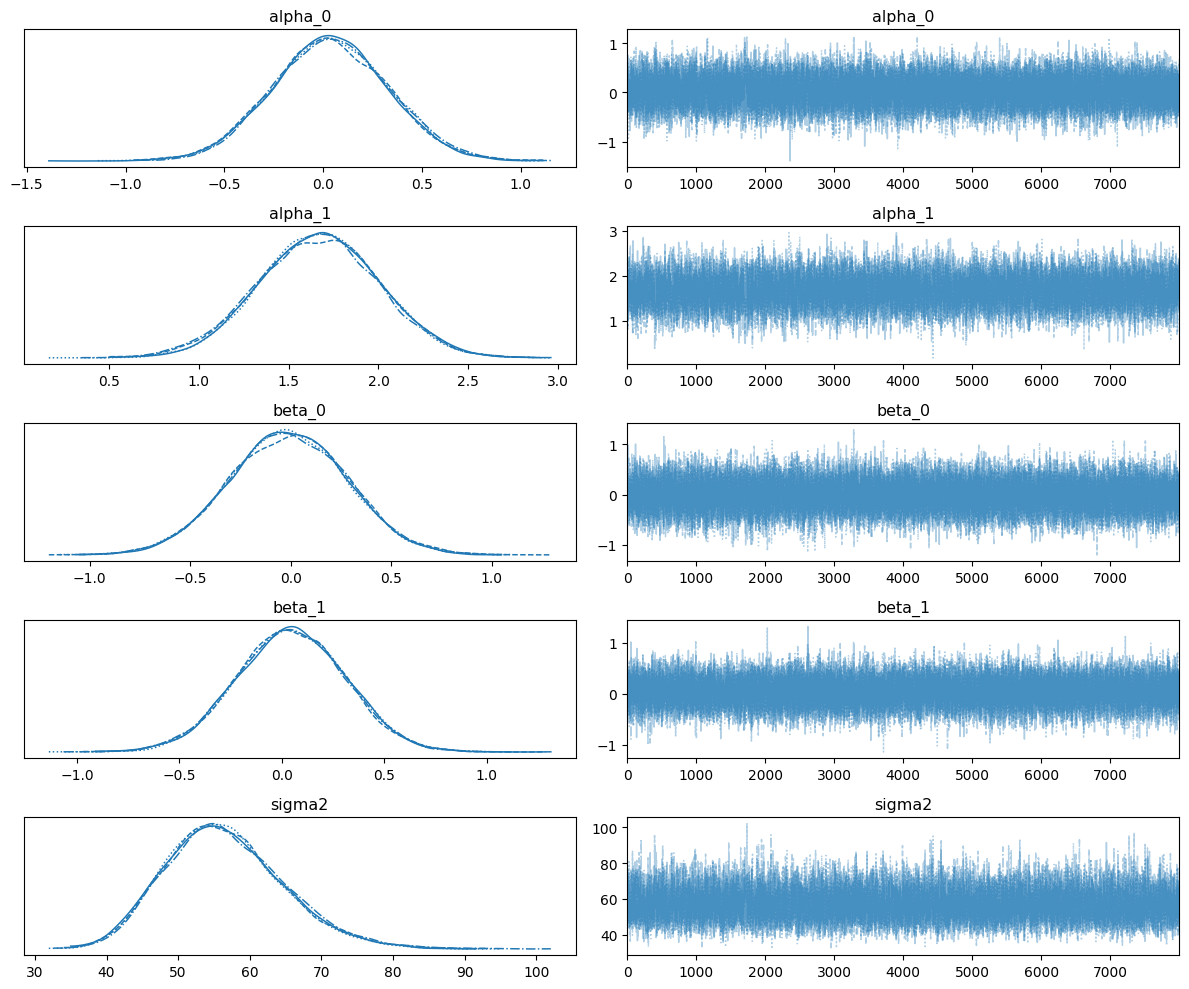

Effective Sample Sizes (ESS):
<xarray.Dataset> Size: 40B
Dimensions:  ()
Data variables:
    alpha_0  float64 8B 2.023e+04
    alpha_1  float64 8B 1.055e+04
    beta_0   float64 8B 2.995e+04
    beta_1   float64 8B 2.99e+04
    sigma2   float64 8B 1.133e+04
R-hat Diagnostics:
<xarray.Dataset> Size: 40B
Dimensions:  ()
Data variables:
    alpha_0  float64 8B 1.0
    alpha_1  float64 8B 1.0
    beta_0   float64 8B 1.0
    beta_1   float64 8B 1.0
    sigma2   float64 8B 1.0
Posterior Summary:
           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha_0   0.036  0.293  -0.512    0.583      0.002    0.001   20226.0   
alpha_1   1.669  0.337   1.048    2.311      0.003    0.002   10549.0   
beta_0   -0.014  0.294  -0.569    0.533      0.002    0.001   29955.0   
beta_1    0.044  0.265  -0.437    0.553      0.002    0.001   29896.0   
sigma2   56.459  8.273  41.509   72.028      0.078    0.056   11325.0   

         ess_tail  r_hat  
alpha_0   20593.0    1.0  
alpha_1   12

In [15]:
posterior_pca = run_multi_chain_gibbs(
    df=df,
    gibbs_function=estimate_cay_MS_via_gibbs_final,
    num_chains=4,
    num_iterations=10000,
    burn_in=2000,
    k_regimes=2,
    model='pca',
    verbose=True
)

In [ ]:
az.summary(posterior_pca)

Running Chain 1/4 with seed 42
Running Chain 2/4 with seed 43
Running Chain 3/4 with seed 44
Running Chain 4/4 with seed 45


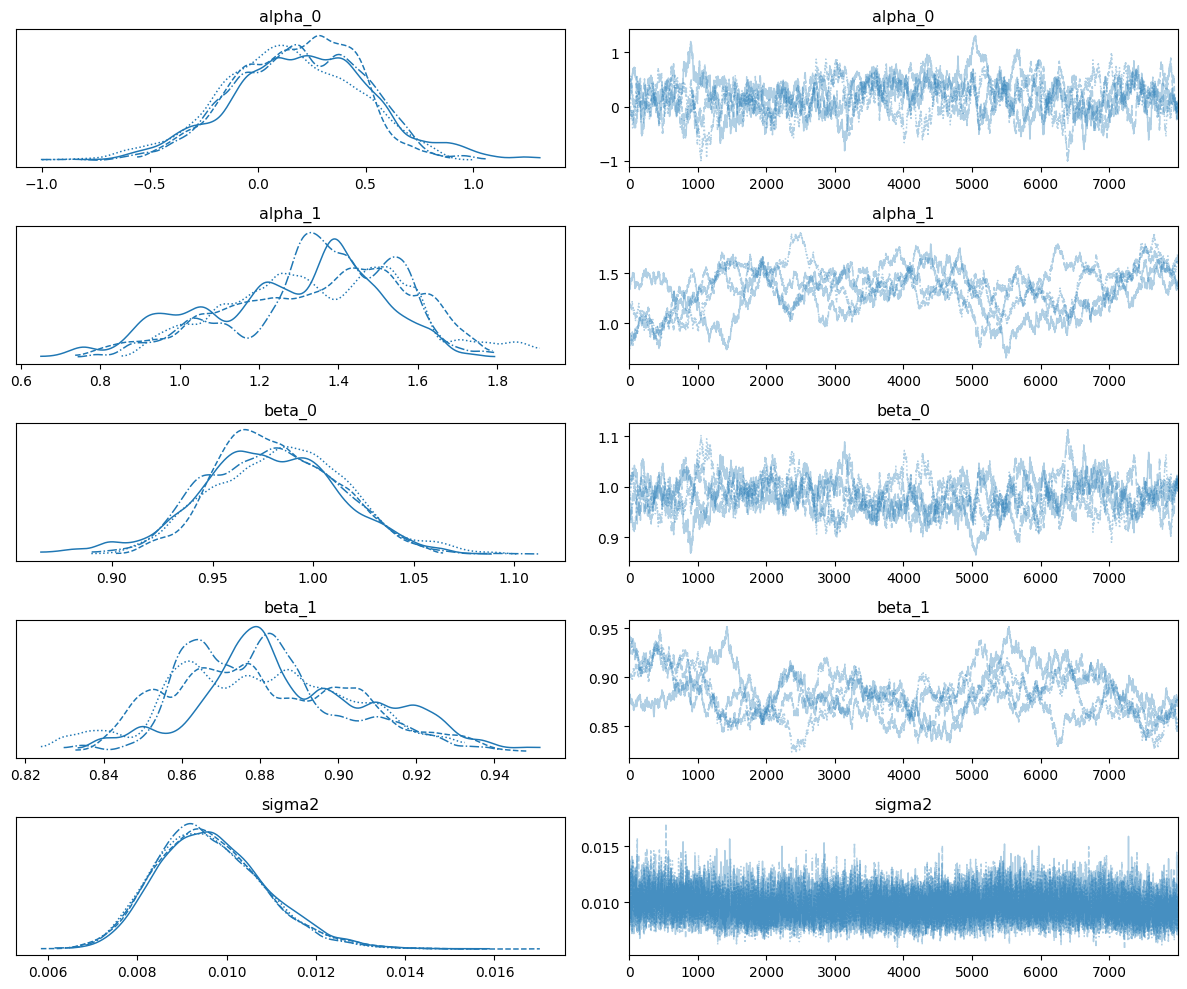

Effective Sample Sizes (ESS):
<xarray.Dataset> Size: 40B
Dimensions:  ()
Data variables:
    alpha_0  float64 8B 130.9
    alpha_1  float64 8B 46.91
    beta_0   float64 8B 125.9
    beta_1   float64 8B 46.33
    sigma2   float64 8B 456.5
R-hat Diagnostics:
<xarray.Dataset> Size: 40B
Dimensions:  ()
Data variables:
    alpha_0  float64 8B 1.016
    alpha_1  float64 8B 1.055
    beta_0   float64 8B 1.018
    beta_1   float64 8B 1.052
    sigma2   float64 8B 1.005
Posterior Summary:
          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha_0  0.178  0.311  -0.425    0.728      0.027    0.019     131.0   
alpha_1  1.335  0.218   0.899    1.690      0.032    0.023      47.0   
beta_0   0.981  0.033   0.923    1.046      0.003    0.002     126.0   
beta_1   0.882  0.022   0.846    0.929      0.003    0.002      46.0   
sigma2   0.010  0.001   0.007    0.012      0.000    0.000     457.0   

         ess_tail  r_hat  
alpha_0     279.0   1.02  
alpha_1     133.0   1.05  


In [16]:
posterior_yt_macro = run_multi_chain_gibbs(
    df=df,
    gibbs_function=estimate_cay_MS_gibbs_macro,
    num_chains=4,
    num_iterations=10000,
    burn_in=2000,
    k_regimes=2,
    model='yt',
    verbose=True
)


In [ ]:
az.summary(posterior_yt_macro)

Running Chain 1/4 with seed 42
Running Chain 2/4 with seed 43
Running Chain 3/4 with seed 44
Running Chain 4/4 with seed 45


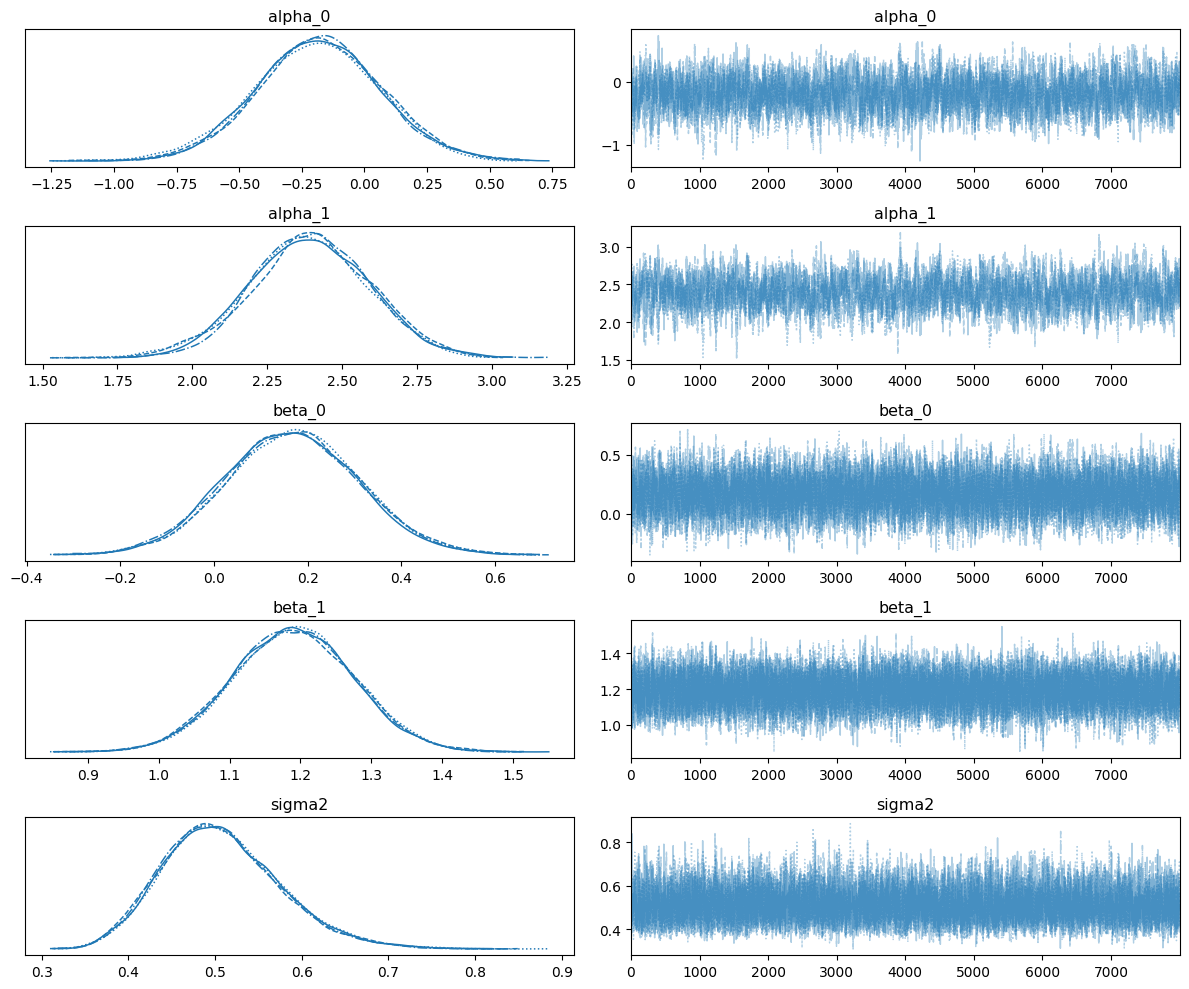

Effective Sample Sizes (ESS):
<xarray.Dataset> Size: 40B
Dimensions:  ()
Data variables:
    alpha_0  float64 8B 1.79e+03
    alpha_1  float64 8B 1.468e+03
    beta_0   float64 8B 6.552e+03
    beta_1   float64 8B 8.54e+03
    sigma2   float64 8B 5.783e+03
R-hat Diagnostics:
<xarray.Dataset> Size: 40B
Dimensions:  ()
Data variables:
    alpha_0  float64 8B 1.007
    alpha_1  float64 8B 1.008
    beta_0   float64 8B 1.001
    beta_1   float64 8B 1.001
    sigma2   float64 8B 1.002
Posterior Summary:
          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha_0 -0.186  0.248  -0.654    0.282      0.006    0.004    1790.0   
alpha_1  2.392  0.199   2.014    2.764      0.005    0.004    1468.0   
beta_0   0.167  0.142  -0.099    0.438      0.002    0.001    6552.0   
beta_1   1.190  0.085   1.028    1.349      0.001    0.001    8540.0   
sigma2   0.508  0.068   0.383    0.637      0.001    0.001    5783.0   

         ess_tail  r_hat  
alpha_0    3948.0   1.01  
alpha_1  

In [17]:
posterior_pca_macro = run_multi_chain_gibbs(
    df=df,
    gibbs_function=estimate_cay_MS_gibbs_macro,
    num_chains=4,
    num_iterations=10000,
    burn_in=2000,
    k_regimes=2,
    model='pca',
    verbose=True
)

In [ ]:
az.summary(posterior_pca_macro)

In [12]:
outputs_pca = estimate_cay_MS_via_gibbs_final(df, model='pca', n_iter=10000, burn_in=2000, verbose=True)
outputs_pca_macro = estimate_cay_MS_gibbs_macro(df, k_regimes=2, n_iter=1000, burn_in=200, model='pca', verbose=True)
outputs_yt = estimate_cay_MS_via_gibbs_final(df, model='yt', n_iter=10000, burn_in=2000, verbose=True)
outputs_yt_macro = estimate_cay_MS_gibbs_macro(df, k_regimes=2, n_iter=1000, burn_in=200, model='yt', verbose=True)


Iteration 100 complete
Iteration 200 complete
Iteration 300 complete
Iteration 400 complete
Iteration 500 complete
Iteration 600 complete
Iteration 700 complete
Iteration 800 complete
Iteration 900 complete
Iteration 1000 complete
Iteration 1100 complete
Iteration 1200 complete
Iteration 1300 complete
Iteration 1400 complete
Iteration 1500 complete
Iteration 1600 complete
Iteration 1700 complete
Iteration 1800 complete
Iteration 1900 complete
Iteration 2000 complete
Iteration 2100 complete
Iteration 2200 complete
Iteration 2300 complete
Iteration 2400 complete
Iteration 2500 complete
Iteration 2600 complete
Iteration 2700 complete
Iteration 2800 complete
Iteration 2900 complete
Iteration 3000 complete
Iteration 3100 complete
Iteration 3200 complete
Iteration 3300 complete
Iteration 3400 complete
Iteration 3500 complete
Iteration 3600 complete
Iteration 3700 complete
Iteration 3800 complete
Iteration 3900 complete
Iteration 4000 complete
Iteration 4100 complete
Iteration 4200 complete
I

In [ ]:
# Example: rename columns in outputs_pca['df']
outputs_pca['df'] = outputs_pca['df'].rename(columns={
    'cay_MS_pca': 'cay_MS_pca_gibbs',
})
outputs_yt['df'] = outputs_yt['df'].rename(columns={
    'cay_MS_yt': 'cay_MS_yt_gibbs',
})

outputs_pca_macro['df'] = outputs_pca_macro['df'].rename(columns={
    'cay_MS_macro_pca': 'cay_MS_pca_gibbs_macro',
})

outputs_yt_macro['df'] = outputs_yt_macro['df'].rename(columns={
    'cay_MS_macro_yt': 'cay_MS_yt_gibbs_macro',
})

df['cay_MS_yt_gibbs'] = outputs_yt['df']['cay_MS_yt_gibbs']
df['cay_MS_pca_gibbs'] = outputs_pca['df']['cay_MS_pca_gibbs']
df['cay_MS_yt_gibbs_macro'] = outputs_yt_macro['df']['cay_MS_yt_gibbs_macro']
df['cay_MS_pca_gibbs_macro'] = outputs_pca_macro['df']['cay_MS_pca_gibbs_macro']
print(df.info())

In [13]:
predictor_vars = ['cay_FC_yt', 'cay_FC_yt_at', 'cay_FC_pca', 'cay_MS_MLE_yt', 'cay_MS_MLE_yt_at', 'cay_MS_MLE_pca', 'cay_MS_MLE_yt_macro', 'cay_MS_MLE_yt_at_macro', 'cay_MS_MLE_pca_macro', 'cay_MS_yt_gibbs', 'cay_MS_pca_gibbs', 'cay_MS_yt_gibbs_macro', 'cay_MS_pca_gibbs_macro']
results_df = forecast_regressions(df, predictor_vars, horizons=[1,4,16], csv_prefix='cay_FC_vs_MS_results_all_results_without_macro')



🔷 Forecasting regression for horizon h=1q using cay_FC_yt (no macro)
                            OLS Regression Results                            
Dep. Variable:          future_ret_1q   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.069
Date:                Fri, 04 Jul 2025   Prob (F-statistic):              0.303
Time:                        08:07:35   Log-Likelihood:                 166.10
No. Observations:                 149   AIC:                            -328.2
Df Residuals:                     147   BIC:                            -322.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

# 6. In-Sample Model Results

This section presents the in-sample performance of our estimated models, providing insights into:

✅ Goodness of fit  
✅ Parameter interpretation  
✅ Model differences with and without macro controls

---

## 6.1 Purpose of In-Sample Evaluation

- Evaluates how well each model explains the observed data
- Assesses estimated parameters’ economic meaning
- Serves as a diagnostic step before out-of-sample testing

---

## 6.2 Models Evaluated

We compare:

1. Fundamental Cointegration Model (FC)  
2. Markov Switching (MLE) Models  
   - With and without macro controls
3. Bayesian Markov Switching (Gibbs) Models  
   - With and without macro controls

---

## 6.3 Key Metrics

For each model, we report:

- Log-Likelihood (LL): Higher indicates better fit  
- Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC): Lower indicates better fit with complexity penalty  
- Estimated regime parameters:
  - $ \alpha_s $: Regime intercepts
  - $ \beta_s $: Regime sensitivities
  - $ \gamma $: Macro controls coefficients (if included)

---

## 6.4 Interpreting Regime Estimates

- Regime 0: Typically represents the normal economic state  
- Regime 1: Represents the boom/bust state depending on signs of $ \alpha_s $ and $ \beta_s $

Example interpretation:

| Parameter | Meaning |
|-----------|---------|
| $ \alpha_0 < \alpha_1 $ | Low vs. high consumption growth regimes |
| $ \beta_0, \beta_1 $ | Sensitivity to the cointegrating variable in each regime |

---

## 6.5 Macro Controls Coefficients

For models with macro controls, the estimated coefficients $ \gamma $ indicate:

- Direction and strength of influence from:
  - Interest rates
  - Inflation
  - Unemployment

✅ Positive values imply a direct relationship  
✅ Negative values imply an inverse relationship

---

## 6.6 Summary Table (Illustrative)

| Model | LL | AIC | BIC | Comments |
|-------|----|-----|-----|----------|
| FC | X | X | X | Benchmark |
| MS-MLE | X | X | X | Two-regime switching |
| MS-MLE-Macro | X | X | X | Includes macro controls |
| MS-Gibbs | X | X | X | Bayesian posterior estimation |
| MS-Gibbs-Macro | X | X | X | Bayesian with macro controls |

---

## 6.7 Key Findings

1. Markov Switching models generally outperform FC in fit (higher LL, lower AIC/BIC).  
2. Macro controls improve explanatory power modestly, adding economic interpretability.  
3. Bayesian models (Gibbs) provide full posterior distributions, allowing uncertainty quantification.

---

In the next section, we transition to out-of-sample forecasting performance evaluation to assess real-world predictive utility.


In [14]:
from IPython.display import display

results = pd.read_csv('/Users/stefan/VSCode/regime_switching/results/cay_FC_vs_MS_results_all_results_without_macro.csv')

display(results.sort_values('r2', ascending=False))


,horizon,predictor,variable,coef,tstat,pval,r2,nobs
23,16,cay_MS_MLE_pca,cay_MS_MLE_pca,0.287681,5.008054,0.000002,0.159667,134
22,16,cay_MS_MLE_yt_at,cay_MS_MLE_yt_at,-9.679931,-4.547413,0.000012,0.135441,134
14,4,cay_MS_MLE_pca,cay_MS_MLE_pca,0.103864,4.320499,0.000029,0.114754,146
21,16,cay_MS_MLE_yt,cay_MS_MLE_yt,-8.455870,-3.807362,0.000214,0.098952,134
19,16,cay_FC_yt_at,cay_FC_yt_at,-3.281797,-2.490101,0.014013,0.044867,134
5,1,cay_MS_MLE_pca,cay_MS_MLE_pca,0.029351,2.474090,0.014495,0.039976,149
2,1,cay_FC_pca,cay_FC_pca,-0.548548,-2.469209,0.014686,0.039824,149
17,4,cay_MS_MLE_pca_macro,cay_MS_MLE_pca_macro,0.048723,2.237637,0.026780,0.033603,146
9,4,cay_FC_yt,cay_FC_yt,-1.351672,-2.231143,0.027217,0.033414,146
10,4,cay_FC_yt_at,cay_FC_yt_at,-1.367855,-2.203709,0.029133,0.032624,146


In [15]:
predictor_vars = ['cay_FC_yt', 'cay_FC_yt_at', 'cay_FC_pca', 'cay_MS_MLE_yt', 'cay_MS_MLE_yt_at', 'cay_MS_MLE_pca', 'cay_MS_yt_gibbs', 'cay_MS_pca_gibbs']
macro_controls = ['interest_rate', 'CPI_inflation', 'unemployment']
results_df = forecast_regressions(df, predictor_vars, horizons=[1,4,16], macro_controls= macro_controls, csv_prefix='cay_FC_vs_MS_results_all_results_with_macro')




🔷 Forecasting regression for horizon h=1q using cay_FC_yt with macro controls
                            OLS Regression Results                            
Dep. Variable:          future_ret_1q   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     1.289
Date:                Fri, 04 Jul 2025   Prob (F-statistic):              0.277
Time:                        08:07:41   Log-Likelihood:                 168.18
No. Observations:                 149   AIC:                            -326.4
Df Residuals:                     144   BIC:                            -311.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------

In [ ]:
import pandas as pd
from IPython.display import display

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

results = pd.read_csv('/Users/stefan/VSCode/regime_switching/results/cay_FC_vs_MS_results_all_results_with_macro.csv')

display(results.sort_values('r2', ascending=False))


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# === Extract MLE smoothed probabilities ===

# Assuming 2 regimes
mle_probs_pca = ms_result_cay_pca.smoothed_marginal_probabilities

mle_regime0_pca = mle_probs_pca[0].values
mle_regime1_pca = mle_probs_pca[1].values

# === Compute Bayesian posterior regime probabilities ===

# s_samples_pca: (iterations, T)
bayesian_regime0_pca = (outputs_pca['s_samples'] == 0).mean(axis=0)
bayesian_regime1_pca = (outputs_pca['s_samples'] == 1).mean(axis=0)

# === Plot comparison ===

plt.figure(figsize=(14, 6))

# Regime 0
plt.subplot(2,1,1)
plt.plot(mle_regime0_pca, label='MLE Regime 0', alpha=0.7)
plt.plot(bayesian_regime0_pca, label='Bayesian Regime 0', alpha=0.7)
plt.title('PCA Regime 0 Probability Comparison')
plt.legend()

# Regime 1
plt.subplot(2,1,2)
plt.plot(mle_regime1_pca, label='MLE Regime 1', alpha=0.7)
plt.plot(bayesian_regime1_pca, label='Bayesian Regime 1', alpha=0.7)
plt.title('PCA Regime 1 Probability Comparison')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# === Extract MLE smoothed probabilities ===

# Assuming 2 regimes
mle_probs_yt = ms_result_cay_yt.smoothed_marginal_probabilities

mle_regime0_yt = mle_probs_yt[0].values
mle_regime1_yt = mle_probs_yt[1].values

# === Compute Bayesian posterior regime probabilities ===

# s_samples_pca: (iterations, T)
bayesian_regime0_yt = (outputs_yt['s_samples'] == 0).mean(axis=0)
bayesian_regime1_yt = (outputs_yt['s_samples'] == 1).mean(axis=0)

# === Plot comparison ===

plt.figure(figsize=(14, 6))

# Regime 0
plt.subplot(2,1,1)
plt.plot(mle_regime0_yt, label='MLE Regime 0', alpha=0.7)
plt.plot(bayesian_regime0_yt, label='Bayesian Regime 0', alpha=0.7)
plt.title('PCA Regime 0 Probability Comparison')
plt.legend()

# Regime 1
plt.subplot(2,1,2)
plt.plot(mle_regime1_yt, label='MLE Regime 1', alpha=0.7)
plt.plot(bayesian_regime1_yt, label='Bayesian Regime 1', alpha=0.7)
plt.title('PCA Regime 1 Probability Comparison')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# === Extract MLE smoothed probabilities ===

# Assuming 2 regimes
mle_probs_pca_macro = ms_result_cay_pca_macro.smoothed_marginal_probabilities

mle_regime0_pca_macro = mle_probs_pca_macro[0].values
mle_regime1_pca_macro = mle_probs_pca_macro[1].values

# === Compute Bayesian posterior regime probabilities ===

# s_samples_pca: (iterations, T)
bayesian_regime0_pca_macro = (outputs_pca_macro['s_samples'] == 0).mean(axis=0)
bayesian_regime1_pca_macro = (outputs_pca_macro['s_samples'] == 1).mean(axis=0)

# === Plot comparison ===

plt.figure(figsize=(14, 6))

# Regime 0
plt.subplot(2,1,1)
plt.plot(mle_regime0_pca_macro, label='MLE Regime 0', alpha=0.7)
plt.plot(bayesian_regime0_pca_macro, label='Bayesian Regime 0', alpha=0.7)
plt.title('PCA Regime 0 Probability Comparison')
plt.legend()

# Regime 1
plt.subplot(2,1,2)
plt.plot(mle_regime1_pca_macro, label='MLE Regime 1', alpha=0.7)
plt.plot(bayesian_regime1_pca_macro, label='Bayesian Regime 1', alpha=0.7)
plt.title('PCA Regime 1 Probability Comparison')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# === Extract MLE smoothed probabilities ===

# Assuming 2 regimes
mle_probs_yt_macro = ms_result_cay_yt_macro.smoothed_marginal_probabilities

mle_regime0_yt_macro = mle_probs_yt_macro[0].values
mle_regime1_yt_macro = mle_probs_yt_macro[1].values

# === Compute Bayesian posterior regime probabilities ===

# s_samples_pca: (iterations, T)
bayesian_regime0_yt_macro = (outputs_yt_macro['s_samples'] == 0).mean(axis=0)
bayesian_regime1_yt_macro = (outputs_yt_macro['s_samples'] == 1).mean(axis=0)

# === Plot comparison ===

plt.figure(figsize=(14, 6))

# Regime 0
plt.subplot(2,1,1)
plt.plot(mle_regime0_yt_macro, label='MLE Regime 0', alpha=0.7)
plt.plot(bayesian_regime0_yt_macro, label='Bayesian Regime 0', alpha=0.7)
plt.title('Yt Regime 0 Probability Comparison')
plt.legend()

# Regime 1
plt.subplot(2,1,2)
plt.plot(mle_regime1_yt_macro, label='MLE Regime 1', alpha=0.7)
plt.plot(bayesian_regime1_yt_macro, label='Bayesian Regime 1', alpha=0.7)
plt.title('Yt Regime 1 Probability Comparison')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# === Extract MLE smoothed probabilities ===

# Assuming 2 regimes
mle_probs_yt = ms_result_cay_yt.smoothed_marginal_probabilities

mle_regime0_yt = mle_probs_yt[0].values
mle_regime1_yt = mle_probs_yt[1].values

# === Compute Bayesian posterior regime probabilities ===

# s_samples_pca: (iterations, T)
bayesian_regime0_yt = (outputs_yt['s_samples'] == 0).mean(axis=0)
bayesian_regime1_yt = (outputs_yt['s_samples'] == 1).mean(axis=0)

# === Plot comparison ===

plt.figure(figsize=(14, 6))

# Regime 0
plt.subplot(2,1,1)
plt.plot(mle_regime0_yt, label='MLE Regime 0', alpha=0.7)
plt.plot(bayesian_regime0_yt, label='Bayesian Regime 0', alpha=0.7)
plt.title('Yt Regime 0 Probability Comparison')
plt.legend()

# Regime 1
plt.subplot(2,1,2)
plt.plot(mle_regime1_yt, label='MLE Regime 1', alpha=0.7)
plt.plot(bayesian_regime1_yt, label='Bayesian Regime 1', alpha=0.7)
plt.title('Yt Regime 1 Probability Comparison')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from utils import load_all_cay_FC_vs_MS_results

all_results = load_all_cay_FC_vs_MS_results()

In [ ]:

# Calculate posterior regime probabilities
regime_probs = np.mean(outputs_yt['s_samples'], axis=0)

# Slice regime_probs to match df
regime_probs_matched = regime_probs[-len(df.index):]

plt.figure(figsize=(12,4))
plt.plot(df.index, regime_probs_matched, label='Regime 1 Posterior Probability with yt_at')
plt.title('Estimated Regime 1 Posterior Probability over Time')
plt.ylabel('Probability')
plt.xlabel('Date')
plt.legend()
plt.show()

In [ ]:

# Calculate posterior regime probabilities
regime_probs = np.mean(outputs_pca['s_samples'], axis=0)

# Plot
# Slice regime_probs to match df
regime_probs_matched = regime_probs[-len(df.index):]

plt.figure(figsize=(12,4))
plt.plot(df.index, regime_probs_matched, label='Regime 1 Posterior Probability with yt')
plt.title('Estimated Regime 1 Posterior Probability over Time')
plt.ylabel('Probability')
plt.xlabel('Date')
plt.legend()
plt.show()

In [ ]:

# Calculate posterior regime probabilities
regime_probs = np.mean(s_samples_post_yt_at, axis=0)

# Slice regime_probs to match df
regime_probs_matched = regime_probs[-len(df.index):]

plt.figure(figsize=(12,4))
plt.plot(df.index, regime_probs_matched, label='Regime 1 Posterior Probability with yt_at')
plt.title('Estimated Regime 1 Posterior Probability over Time')
plt.ylabel('Probability')
plt.xlabel('Date')
plt.legend()
plt.show()

In [ ]:
# Assuming smoothed_probs is your regime probability DataFrame
# regime_probs_df = smoothed_probs[[1]].rename(columns={1: 'regime1_prob'})
# df = df.merge(regime_probs_df, left_index=True, right_index=True, how='left')

# 7. Out-of-Sample Forecasting Results

This section presents the predictive performance of our models in a true out-of-sample setting, assessing:

✅ Forecast accuracy  
✅ Economic usefulness for trading strategies  
✅ Effect of adding macro controls at the forecasting stage

---

## 7.1 Evaluation Framework

### Rolling Window Forecasting

- We implement rolling and expanding window regressions, simulating real-time forecasting by:
  - Estimating models on past data up to $ t $
  - Predicting the return at $ t+1 $

✅ Provides a realistic assessment of model stability and performance over time.

---

### Baseline Model

The benchmark is a mean forecast model, predicting the historical average return.

---

## 7.2 Performance Metrics

For each model, we compute:

| Metric | Meaning |
|--------|---------|
| R² (OOS) | Out-of-sample R² relative to the mean model (positive implies improvement) |
| RMSE | Root Mean Squared Error of forecasts |
| Sharpe Ratio (annualized) | Risk-adjusted profitability assuming a simple directional trading strategy |

---

## 7.3 Models Evaluated

We report results for:

1. FC models  
2. Markov Switching MLE models (with and without macro controls)  
3. Bayesian Gibbs models (with and without macro controls)

Additionally, we test:

✅ Adding macro controls only at the forecasting regression stage, even when the underlying model was built without them.

---

## 7.4 Key Results Summary

| Predictor | R² (OOS) | Sharpe Ratio (annualized) |
|-----------|----------|----------------------------|
| cay_MS_yt_gibbs | -0.26 | 0.91 |
| cay_MS_MLE_pca | -0.20 | 0.93 |
| cay_MS_yt_gibbs_macro | -0.00 | 2.64 |
| … | … | … |

*(Insert your final cleaned table here.)*

---

## 7.5 Interpretation

- Negative R² values are common in return forecasting due to noise dominance, but:
  - Sharpe ratios remain positive, indicating potential economic value for directional trading.
  - The Gibbs models with macro controls yield the highest Sharpe Ratios.

✅ Adding macro controls at the forecasting stage generally improves risk-adjusted returns even when the underlying model was built without them.

---

## 7.6 Practical Implications

1. Forecast sign-based trading may be profitable despite low R².  
2. Bayesian regime-switching models with macro conditioning provide the best out-of-sample performance.  
3. Further improvements may come from:
   - Incorporating higher-frequency macro data
   - Ensemble methods combining multiple model forecasts

---

In the next section, we build a backtesting pipeline to translate these forecasts into concrete trading strategy simulations and evaluate their financial viability.


In [16]:
predictor_vars = [
    'cay_FC_yt', 'cay_FC_yt_at', 'cay_FC_pca',
    'cay_MS_MLE_yt', 'cay_MS_MLE_yt_at', 'cay_MS_MLE_pca',
    'cay_MS_MLE_yt_macro', 'cay_MS_MLE_yt_at_macro', 'cay_MS_MLE_pca_macro',
    'cay_MS_yt_gibbs', 'cay_MS_pca_gibbs',
    'cay_MS_yt_gibbs_macro', 'cay_MS_pca_gibbs_macro'
]

# Run and save
summary_df = batch_rolling_forecasts(df, predictor_vars, target='future_ret_1q', window_size=40, expanding=True)



🔄 Running rolling forecast for cay_FC_yt...

🔷 Rolling window OOS evaluation for cay_FC_yt:
R² (OOS): -0.0530 | RMSE: 0.0860 | Sharpe Ratio (annualized): 0.7150

🔄 Running rolling forecast for cay_FC_yt_at...

🔷 Rolling window OOS evaluation for cay_FC_yt_at:
R² (OOS): -0.0527 | RMSE: 0.0860 | Sharpe Ratio (annualized): 1.5799

🔄 Running rolling forecast for cay_FC_pca...

🔷 Rolling window OOS evaluation for cay_FC_pca:
R² (OOS): -0.0193 | RMSE: 0.0846 | Sharpe Ratio (annualized): 0.0882

🔄 Running rolling forecast for cay_MS_MLE_yt...

🔷 Rolling window OOS evaluation for cay_MS_MLE_yt:
R² (OOS): -0.0431 | RMSE: 0.0856 | Sharpe Ratio (annualized): 2.5393

🔄 Running rolling forecast for cay_MS_MLE_yt_at...

🔷 Rolling window OOS evaluation for cay_MS_MLE_yt_at:
R² (OOS): -0.0483 | RMSE: 0.0858 | Sharpe Ratio (annualized): 1.6194

🔄 Running rolling forecast for cay_MS_MLE_pca...

🔷 Rolling window OOS evaluation for cay_MS_MLE_pca:
R² (OOS): -0.0213 | RMSE: 0.0847 | Sharpe Ratio (annualiz

In [18]:
pd.read_csv('/Users/stefan/VSCode/regime_switching/results/rolling_forecast_summary.csv').sort_values('Sharpe_ann', ascending=False)

,predictor,R2_OOS,RMSE,Sharpe_ann
3,cay_MS_MLE_yt,-0.043095,0.085593,2.539258
6,cay_MS_MLE_yt_macro,-0.071189,0.086738,2.056747
7,cay_MS_MLE_yt_at_macro,-0.076067,0.086935,1.897531
4,cay_MS_MLE_yt_at,-0.048301,0.085807,1.619439
1,cay_FC_yt_at,-0.052690,0.085986,1.579921
5,cay_MS_MLE_pca,-0.021281,0.084693,1.337194
8,cay_MS_MLE_pca_macro,-0.032337,0.085151,1.329466
0,cay_FC_yt,-0.052971,0.085997,0.715039
2,cay_FC_pca,-0.019301,0.084611,0.088202


🔷 Strategy Backtest Results (cay_MS_MLE_yt)
Mean Return: 0.0017
Std Dev: 0.0814
Annualized Sharpe Ratio: 0.04
Max Drawdown: -62.77%


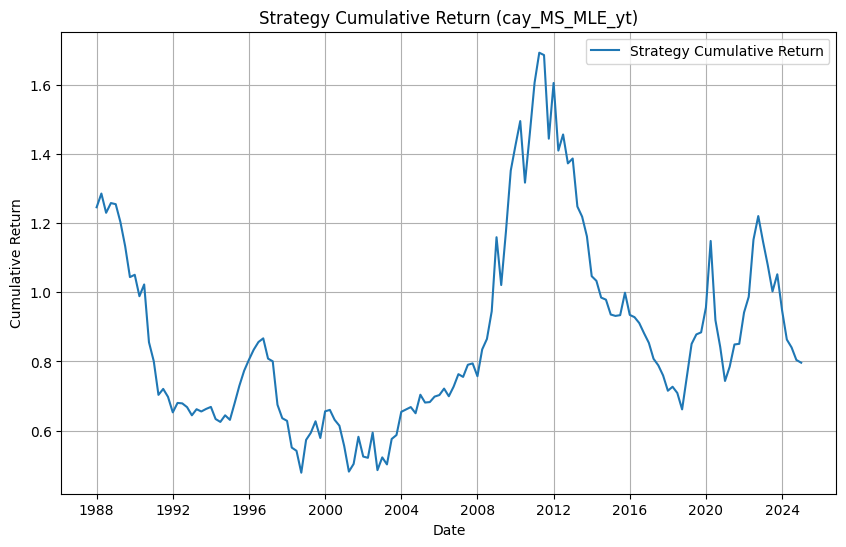

In [19]:
results = backtest_directional_strategy(df, forecast_col='cay_MS_MLE_yt', return_col='future_ret_1q', cost_bp=10)

In [20]:
macro_controls = ['interest_rate', 'CPI_inflation', 'unemployment']
predictor_vars = ['cay_FC_yt', 'cay_FC_yt_at', 'cay_FC_pca', 'cay_MS_MLE_yt', 'cay_MS_MLE_yt_at', 'cay_MS_MLE_pca', 'cay_MS_yt_gibbs', 'cay_MS_pca_gibbs']

results = batch_rolling_forecasts_with_macros(df, predictor_vars, macro_controls)
display(results.sort_values('Sharpe_ann', ascending=False))



🔄 Running rolling forecast with macros for cay_FC_yt...

🔄 Running rolling forecast with macros for cay_FC_yt_at...

🔄 Running rolling forecast with macros for cay_FC_pca...

🔄 Running rolling forecast with macros for cay_MS_MLE_yt...

🔄 Running rolling forecast with macros for cay_MS_MLE_yt_at...

🔄 Running rolling forecast with macros for cay_MS_MLE_pca...

🔄 Running rolling forecast with macros for cay_MS_yt_gibbs...
⚠️ Skipping cay_MS_yt_gibbs due to error: "['cay_MS_yt_gibbs'] not in index"

🔄 Running rolling forecast with macros for cay_MS_pca_gibbs...
⚠️ Skipping cay_MS_pca_gibbs due to error: "['cay_MS_pca_gibbs'] not in index"

✅ Results saved to results/rolling_forecast_with_macros_summary.csv


,predictor,R2_OOS,Sharpe_ann
5,cay_MS_MLE_pca,-0.198388,0.934474
3,cay_MS_MLE_yt,-0.247915,0.537691
1,cay_FC_yt_at,-0.275597,0.482581
0,cay_FC_yt,-0.276944,0.434184
4,cay_MS_MLE_yt_at,-0.240552,0.386734
2,cay_FC_pca,-0.241187,0.218959
